In [1]:
import cartopy as car
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import filtfilt, cheby1, butter, lombscargle, argrelmax, welch, periodogram,  argrelextrema
import pickle
from scipy.stats import pearsonr
import pandas as pd
import netCDF4 as nc
from datetime import date, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
with open('t.pkl', 'rb') as file: # read JJA time series data
    full = pickle.load(file)

In [3]:
#with open('data/ts_up.pkl', 'rb') as file:
   # full = pickle.load(file)

In [4]:
with open('ts_modified.pkl', 'rb') as file:
    full_m = pickle.load(file)

In [5]:
def cheby_lowpass(cutoff, fs, order, rp):  # 为了filter服务的
    nyq = 0.5 * fs
    normal_cutoff = cutoff/ nyq
    b, a = cheby1(order, rp, normal_cutoff, btype = "low", analog = False)
    return b, a
'''
scipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.
fs: the sampling frequency of the digital system.
rp: the max ripple allowed below unity gain in the passband. 
'''

'\nscipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.\nfs: the sampling frequency of the digital system.\nrp: the max ripple allowed below unity gain in the passband. \n'

In [6]:
def cheby_lowpass_filter(x, cutoff, fs, order, rp):
    b, a = cheby_lowpass(cutoff, fs, order ,rp)
    y = filtfilt(b, a, x)
    return y
'''
filtfilt: Apply a digital filter forward and backward to a signal.
'''

'\nfiltfilt: Apply a digital filter forward and backward to a signal.\n'

In [7]:
def JJA_date_generate(y1, y2):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJA_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, 6, 1)
        for n in range(92):
            delta = now - start
            JJA_dates.append(delta.days)
            now += timedelta(days=1)
    return JJA_dates

In [8]:
def date_in_month(days):
    '''find what month is that'''
    star = date(1998, 1 ,1)
    now = star + timedelta(days=days)
    return now.strftime("%Y%m%d")

In [9]:
JJA = JJA_date_generate(1998, 2016)
len(JJA)

1748

In [10]:
# sca - A, euro - B 
cutoff = 10
sca_euro = cheby_lowpass_filter(full['t'][0] + full['t12'][0], 0.95 * 1. / cutoff, 1, 8, .05)
euro_sca = cheby_lowpass_filter(full['t'][0] + full['t21'][0], 0.95 * 1. / cutoff, 1, 8, .05)

In [11]:
#JJA season
percen = (np.percentile(sca_euro[JJA], 90), np.percentile(euro_sca[JJA], 90),)
percen

(7104.384233485838, 7960.612643732678)

In [12]:
local_max_index = {}
local_max_index['AB'] =  argrelextrema(sca_euro, np.greater)[0]
local_max_index['BA'] = argrelextrema(euro_sca, np.greater)[0]

In [13]:
print(len(local_max_index['AB']), len(local_max_index['BA']))

597 613


In [14]:
AB_lomax = sca_euro[local_max_index['AB']]
bo_lomax = np.array([a > percen[0] for a in AB_lomax])
BA_lomax = euro_sca[local_max_index['BA']]
bo_lomax_2 = np.array([a > percen[1] for a in BA_lomax])

In [15]:
loc_max_AB = np.vstack((AB_lomax, local_max_index['AB']))
print(loc_max_AB.shape)
loc_max_BA = np.vstack((BA_lomax, local_max_index['BA']))
print(loc_max_BA.shape)

(2, 597)
(2, 613)


In [16]:
AB_pass = []
for n in range(587):
    if bo_lomax[n]:
        AB_pass.append(loc_max_AB[:,n])

BA_pass = []
for n in range(605):
    if bo_lomax_2[n]:
        BA_pass.append(loc_max_BA[:,n])

In [17]:
len(BA_pass)

58

In [18]:
# select those in JJA
AB_pass_JJA = [n for n in AB_pass if n[1] in JJA]
BA_pass_JJA = [n for n in BA_pass if n[1] in JJA]

In [19]:
len(BA_pass_JJA), len(AB_pass_JJA)

(36, 29)

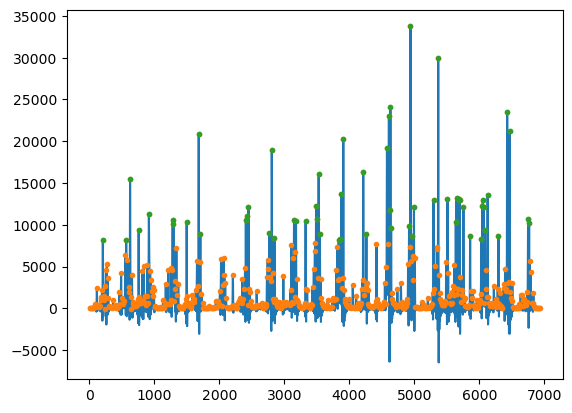

In [20]:
# plot of the fillted time series BA and local max
plt.plot(range(6940), euro_sca)
plt.plot(local_max_index['BA'], euro_sca[local_max_index['BA']], '.')
plt.plot([B[1] for B in BA_pass ], [B[0] for B in BA_pass ], '.')

In [21]:
start = date(1998, 1, 1)
Date_AB_inter = [(start + timedelta(days=d[1])).strftime("%Y%m%d") for d in AB_pass_JJA]
Date_BA_inter = [(start + timedelta(days=d[1])).strftime("%Y%m%d") for d in BA_pass_JJA]

In [22]:
# load the average precipitation of JJA season
with open('JJA_average.pkl', 'rb') as file:
    JJA_average = pickle.load(file)

In [23]:
pcp_BA = [] # read the interested dates data
years = [n for n in range(1998,2017)]
for d in Date_BA_inter:
    #change this according to the position
    string = 'data/' +  d + '.nc4'
    nc_da = nc.Dataset(string)
    pcp_BA.append(nc_da['precipitation'][:])
pcp_BA = np.array(pcp_BA)

In [24]:
pcp_BA.shape

(36, 1440, 400)

In [25]:
anomalies =  pcp_BA - JJA_average
print(anomalies.shape)
com_anomalies = np.mean(anomalies, axis=0)
print(com_anomalies.shape)

(36, 1440, 400)
(1440, 400)


In [26]:
com_anomalies_clipped = np.clip(com_anomalies, -5, 5) # clipped the value above 5 and below -5
com_anomalies_clipped.shape

(1440, 400)

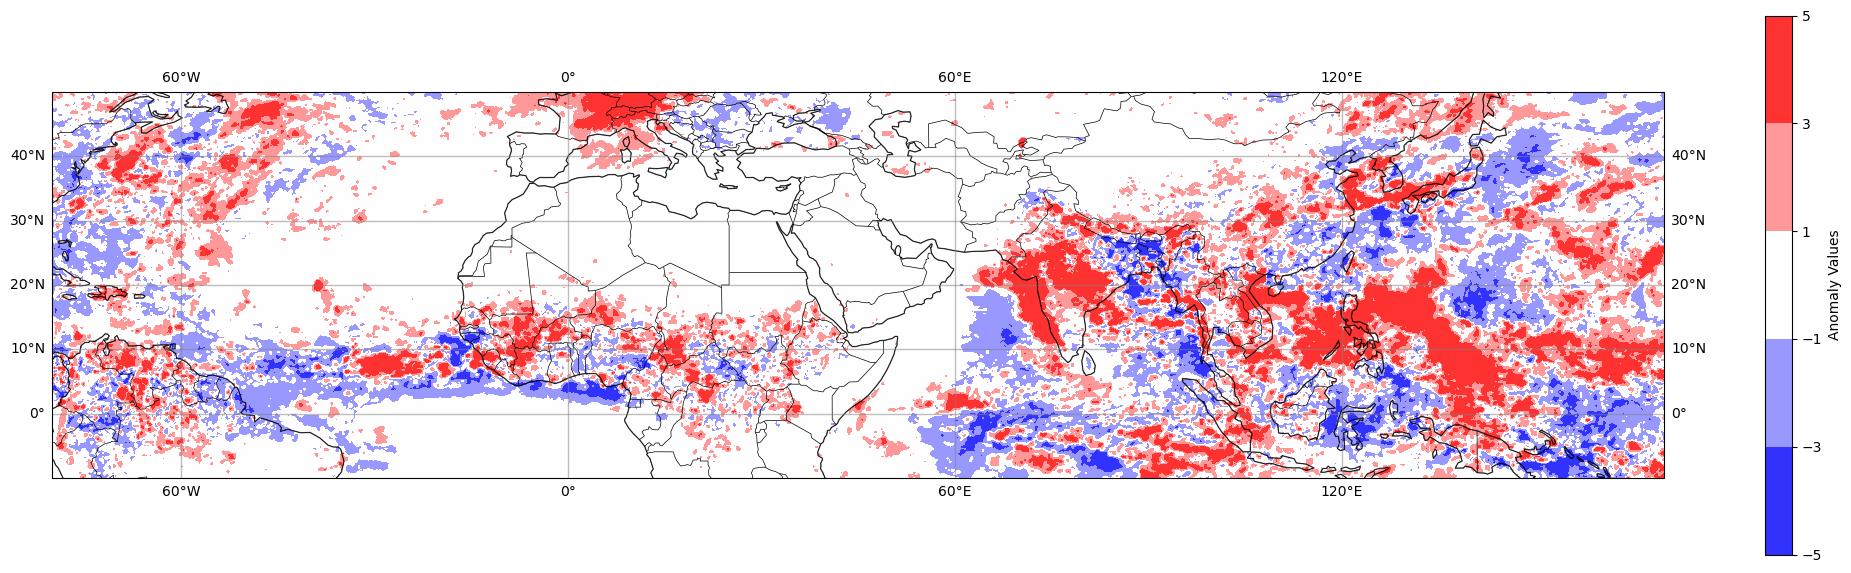

In [50]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
# extent = [-90, 90, -360, 0]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels = np.arange(-5, 7 ,2 )  # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(-179.875,179.875,1440), np.linspace(-49.875,49.875,400), com_anomalies_clipped.T, levels=levels, cmap='bwr', transform=ccrs.PlateCarree())

plt.xlim([-80,170])
plt.ylim([-10,50])

# Add a colorbar
cbar = plt.colorbar(contour, shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
# gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
# gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.savefig('Figure4_b.jpg',dpi=300)
plt.show()


In [28]:
# add 3 days to the final interested dates
Date_BA_inter_3 = [(start + timedelta(days=d[1]+3)).strftime("%Y%m%d") for d in BA_pass_JJA]

In [29]:
pcp_BA_3 = [] # read the interested dates data
years = [n for n in range(1998,2017)]
for d in Date_BA_inter_3:
    #change this according to the position
    string = 'data/' +  d + '.nc4'
    nc_da = nc.Dataset(string)
    pcp_BA_3.append(nc_da['precipitation'][:])
pcp_BA_3 = np.array(pcp_BA_3)

In [30]:
anomalies =  pcp_BA_3 - JJA_average
print(anomalies.shape)
com_anomalies_r = np.mean(anomalies, axis=0)
print(com_anomalies_r.shape)

(36, 1440, 400)
(1440, 400)


In [31]:
com_anomalies_clipped_r = np.clip(com_anomalies_r, -5, 5)
# clipped value above 5 and below -5
com_anomalies_clipped_r.shape

(1440, 400)

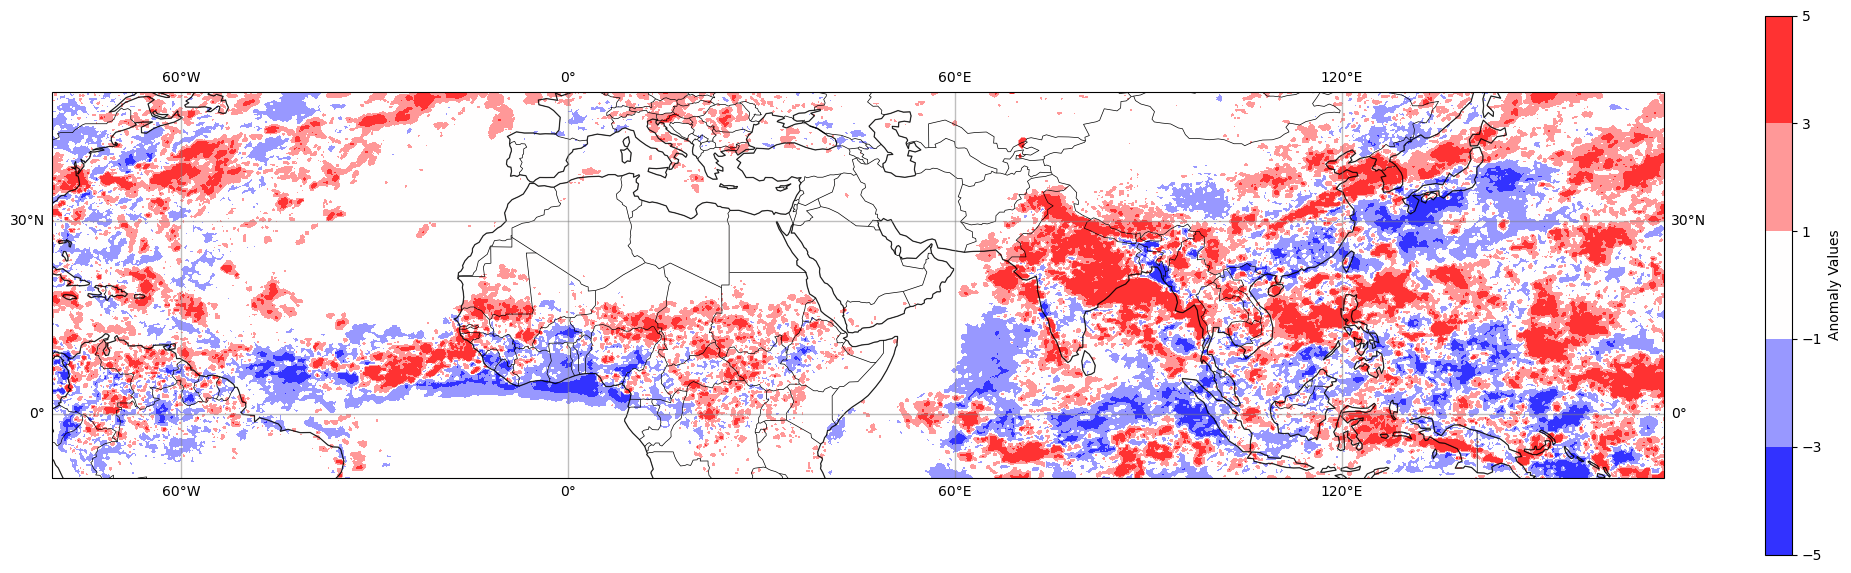

In [51]:

# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-179.875, 179.875, -49.875, 49.875]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels = np.arange(-5, 7 ,2 )  # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(-179.875,179.875,1440), np.linspace(-49.875,49.875,400), com_anomalies_clipped_r.T, levels=levels, cmap='bwr', transform=ccrs.PlateCarree())

plt.xlim([-80,170])
plt.ylim([-10,50])
# Add a colorbar
cbar = plt.colorbar(contour, shrink=0.7)

cmin, cmax = -5, 5
cbar_norm = plt.Normalize(vmin=cmin, vmax=cmax)
contour.set_norm(cbar_norm)
cbar.set_label('Anomaly Values')
# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.savefig('Figure4_c.jpg',dpi=300)
plt.show()